## Introduction

Brain tumor detection is a critical task in medical imaging that can significantly impact patient prognosis and treatment planning. Magnetic Resonance Imaging (MRI) provides high-resolution, non-invasive views of the brain’s internal structures, making it the modality of choice for identifying and monitoring intracranial lesions.

In this project, we will develop a **binary convolutional neural network (CNN) classifier** to automatically distinguish between MRI slices that contain a tumor and those that do not. Leveraging the “Brain Tumor Multimodal Image (CT & MRI)” dataset from Kaggle, we will:

1. **Curate and relabel** the MRI subset into two categories:  
   - **Tumor** (glioma, meningioma, pituitary)  
   - **No Tumor** (healthy controls)

2. **Preprocess and augment** the images to standardize input size, normalize intensities, and increase robustness against overfitting.

3. **Design and train** a sequential CNN architecture, combining convolutional blocks, batch normalization, pooling, and dropout, followed by a fully connected head with a sigmoid output for binary classification.

4. **Optimize and regularize** the training using callbacks such as learning‐rate scheduling (ReduceLROnPlateau) and EarlyStopping to prevent overfitting.

5. **Evaluate** model performance on a held‐out test set using accuracy, confusion matrix, precision/recall, and ROC–AUC metrics.


### 2. Imports & Environment Check

Import required libraries and verify them


In [3]:
from ssl import SSLSocket

import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras (bundled):", tf.__version__) 


TensorFlow: 2.17.0
Keras (bundled): 2.17.0


In [4]:
import sys
print("Python:", sys.version)

Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [5]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import tensorflow as ts

from sklearn.model_selection import train_test_split


### 3. Load Dataset & Create DataFrame

- Walk through the dataset directory and collect image file paths and their corresponding labels  
- Construct a Pandas DataFrame with columns `filepath` and `label`  
- Perform a stratified train/validation/test split (70%/15%/15%) to preserve class distribution  
- Extract file path and label series for each split: `x_train, y_train`, `x_val, y_val`, and `x_test, y_test`


In [6]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

base_path = "Data/Dataset/Brain Tumor MRI images"

image_paths = []
labels = []

for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for img_path in glob.glob(os.path.join(label_path, "*")):
            image_paths.append(img_path)
            labels.append(label)

df = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
})

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train:", train_df["label"].value_counts())
print("Val:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

x_train, y_train = train_df["filepath"], train_df["label"]
x_val, y_val = val_df["filepath"], val_df["label"]
x_test, y_test = test_df["filepath"], test_df["label"]


Train: label
Tumor      2100
Healthy    1400
Name: count, dtype: int64
Val: label
Tumor      450
Healthy    300
Name: count, dtype: int64
Test: label
Tumor      450
Healthy    300
Name: count, dtype: int64


### 4. Visualize Sample Images

Display a grid of 64 images from the training set to inspect the appearance of “Healthy” vs. “Tumor” scans. This helps verify data integrity and class balance before training.


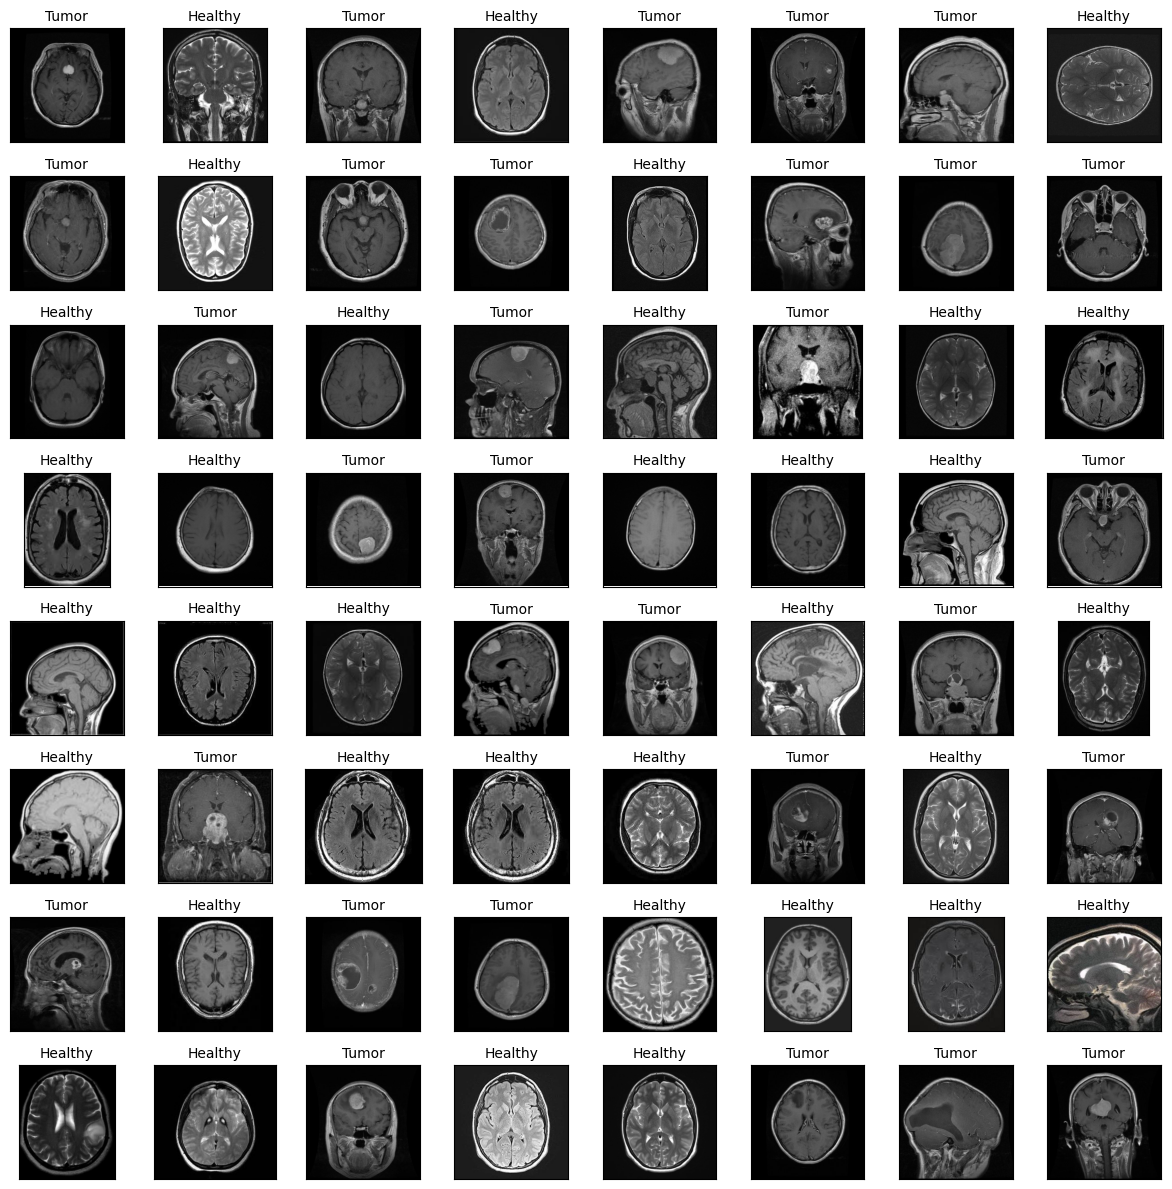

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

imgs = x_train
labs = y_train

class_names = ['Healthy', 'Tumor']

plt.figure(figsize=(12, 12))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    img_path = imgs.iloc[i]
    label = labs.iloc[i]

    img = Image.open(img_path)
    plt.imshow(img, cmap='gray' if img.mode == 'L' else None)
    plt.title(label, fontsize=10)

plt.tight_layout()
plt.show()


### 5. Load, Resize & Normalize Images

- Define a helper function `load_images()` to:
  - Open each image in RGB mode  
  - Resize to a fixed spatial resolution (128×128)  
  - Convert to a NumPy array with `float32` dtype  
- Load training, validation, and test sets into `X_train`, `X_valid`, and `X_test`  
- Compute the global mean and standard deviation on `X_train`  
- Normalize all splits by subtracting the mean and dividing by the standard deviation (with a small epsilon to avoid division by zero)


In [8]:
def load_images(paths, size=(128, 128)):
    data = []
    for path in paths:
        img = Image.open(path).convert("RGB")
        img = img.resize(size)
        data.append(np.array(img))
    return np.array(data, dtype='float32')

X_train = load_images(x_train)
X_valid = load_images(x_val)
X_test  = load_images(x_test)
mean = np.mean(X_train)
std  = np.std(X_train)

X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

In [9]:
print(X_train.dtype)
print(X_train.shape)


float32
(3500, 128, 128, 3)


In [10]:
print(y_train)

3412      Tumor
688     Healthy
4049      Tumor
1170    Healthy
3021      Tumor
         ...   
2732      Tumor
2357      Tumor
1172    Healthy
4419      Tumor
4264      Tumor
Name: label, Length: 3500, dtype: object


### 6. Encode Labels

- Use `LabelEncoder` to convert textual labels (“Healthy”, “Tumor”) into integer classes  
- Apply `to_categorical` to transform integer labels into one-hot vectors for the two output neurons  
- Print the class mapping to verify label order


In [11]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val   = encoder.transform(y_val)
y_test  = encoder.transform(y_test)

y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_val, 2)
y_test  = to_categorical(y_test, 2)

print("Class mapping:", encoder.classes_)  # ['Healthy', 'Tumor']


Class mapping: ['Healthy' 'Tumor']


### 7. Data Augmentation

Define real-time image augmentation to enrich the training set and improve generalization by applying random transformations:

- **rotation_range=10**: Randomly rotate images by up to ±10°
- **width_shift_range=0.03**: Horizontally shift images by up to 3% of the width
- **height_shift_range=0.05**: Vertically shift images by up to 5% of the height
- **horizontal_flip=True**: Randomly flip images left-to-right
- **zoom_range=0.05**: Zoom in on images by up to 5%


In [12]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=10,

    width_shift_range=0.03,

    height_shift_range=0.05,

    horizontal_flip=True,

    zoom_range=0.05

)

### 9. Define CNN First Model Architecture

- **Conv Block 1**  
  - `Conv2D(16, 3×3, relu, same)`  
  - `BatchNormalization()`  
  - `MaxPooling2D(2×2)`  

- **Conv Block 2**  
  - `Conv2D(32, 3×3, relu, same)`  
  - `BatchNormalization()`  
  - `MaxPooling2D(2×2)`  
  - `Dropout(0.3)`  

- **Classifier Head**  
  - `Flatten()` to vectorize feature maps  
  - `Dense(64, relu)` fully connected layer  
  - `Dense(2, softmax)` output layer for “Healthy” vs. “Tumor”  


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


model = Sequential()
    
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
    
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 10. Model Summary

Use `model.summary()` to print a table of each layer in the network, showing:

- **Layer (type)**: Name and layer class  
- **Output Shape**: The dimensions after each layer  
- **Param**: Number of trainable parameters per layer  

This helps verify that the architecture matches your design and gives a count of total parameters.


In [16]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,626 (8.02 MB)

 Trainable params: 2,102,530 (8.02 MB)

 Non-trainable params: 96 (384.00 B)


### 11. Training Configuration & Execution

In this step, we’ll:

1. **Set hyperparameters**:  
   - `batch_size = 32` (samples per gradient update)  
   - `epochs = 100` (maximum full passes through the training set)

2. **Compile the model** with:  
   - **Optimizer**: Adam (learning rate = 0.0005)  
   - **Loss**: `categorical_crossentropy`  
   - **Metric**: `accuracy`

3. **Configure callbacks** for robust training:  
   - **ReduceLROnPlateau**: monitor `val_loss`, halve LR if no improvement for 5 epochs (min LR = 1e-5)  
   - **EarlyStopping**: monitor `val_loss`, stop after 10 epochs without improvement, and restore best weights

4. **Launch training** using the augmented data generator, validating at each epoch, and applying the callbacks.

In [17]:
batch_size = 32

epochs = 100

optimizer = Adam(learning_rate=0.0005)


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

model.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


Epoch 1/100


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 24s - 215ms/step - accuracy: 0.7177 - loss: 0.7621 - val_accuracy: 0.7533 - val_loss: 0.6096 - learning_rate: 5.0000e-04
Epoch 2/100
110/110 - 24s - 217ms/step - accuracy: 0.8660 - loss: 0.3085 - val_accuracy: 0.7533 - val_loss: 0.5946 - learning_rate: 5.0000e-04
Epoch 3/100
110/110 - 21s - 192ms/step - accuracy: 0.8957 - loss: 0.2418 - val_accuracy: 0.8760 - val_loss: 0.3107 - learning_rate: 5.0000e-04
Epoch 4/100
110/110 - 20s - 185ms/step - accuracy: 0.9151 - loss: 0.2019 - val_accuracy: 0.8907 - val_loss: 0.2507 - learning_rate: 5.0000e-04
Epoch 5/100
110/110 - 21s - 188ms/step - accuracy: 0.9249 - loss: 0.1860 - val_accuracy: 0.9093 - val_loss: 0.2319 - learning_rate: 5.0000e-04
Epoch 6/100
110/110 - 20s - 183ms/step - accuracy: 0.9300 - loss: 0.1703 - val_accuracy: 0.9347 - val_loss: 0.1853 - learning_rate: 5.0000e-04
Epoch 7/100
110/110 - 20s - 184ms/step - accuracy: 0.9477 - loss: 0.1517 - val_accuracy: 0.9587 - val_loss: 0.1430 - learning_rate: 5.0000e-04
Epoch 8/100

After training, plot the evolution of loss and accuracy for both training and validation sets to assess model convergence and detect overfitting:

- **Left subplot**:  
  - `Train Loss` vs. `Validation Loss` over epochs  
  - Helps identify if validation loss starts increasing (overfitting) or plateaus.

- **Right subplot**:  
  - `Train Accuracy` vs. `Validation Accuracy` over epochs  
  - Shows how well the model learns and generalizes.


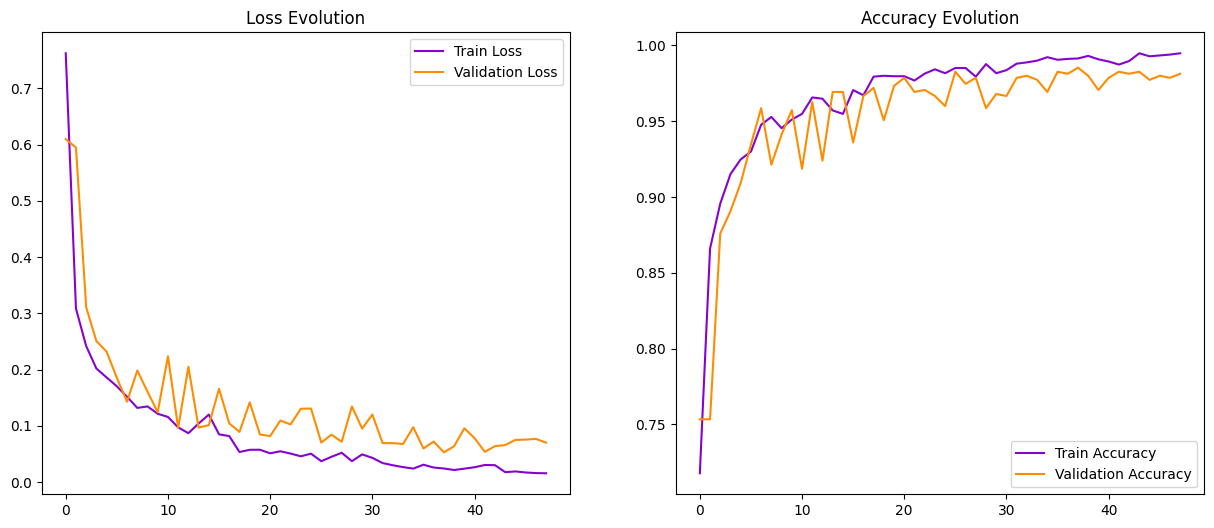

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

### 12. Model Evaluation on Test Set

Evaluate the final model on the held-out test set to assess generalization performance:

- **`model.evaluate()`** computes the loss and accuracy on `X_test, y_test`.  
- Print out the **Test Accuracy** and **Test Loss** to summarize performance.

```python
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)  # e.g. 0.9853
print('Test Loss:    ', test_loss)  # e.g. 0.0746


In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9796 - loss: 0.1153

Test Accuracy: 0.9853333234786987
Test Loss:     0.0745590329170227


### 13. Confusion Matrix & Classification Report

- Predict class probabilities on the test set and convert to discrete class labels  
- Compute the confusion matrix to see True/False Positives/Negatives  
- Plot the confusion matrix as a heatmap with class labels “Healthy” and “Tumor”  
- Generate a detailed classification report (precision, recall, F1‐score) for each class  


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


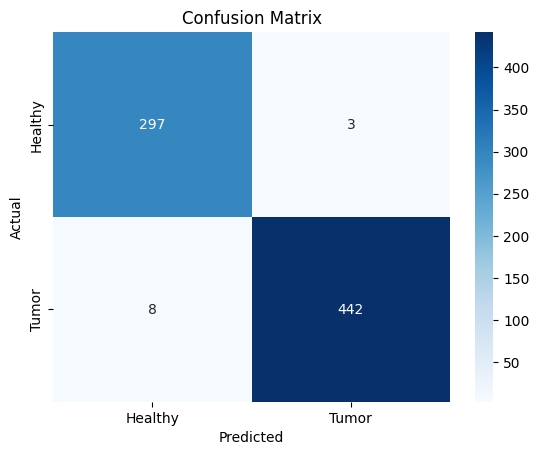

              precision    recall  f1-score   support

     Healthy       0.97      0.99      0.98       300
       Tumor       0.99      0.98      0.99       450

    accuracy                           0.99       750
   macro avg       0.98      0.99      0.98       750
weighted avg       0.99      0.99      0.99       750



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


### 14. Results Interpretation

The model achieves excellent performance on the test set, as shown by the confusion matrix and classification report:

- **Healthy class**  
  - **Precision = 0.97**: When the model predicts “Healthy,” it is correct 97% of the time.  
  - **Recall = 0.99**: It detects 99% of actual healthy scans correctly.  
  - **F1-score = 0.98**: The harmonic mean of precision and recall shows balanced performance.

- **Tumor class**  
  - **Precision = 0.99**: When the model predicts “Tumor,” it is correct 99% of the time.  
  - **Recall = 0.98**: It detects 98% of actual tumor scans correctly.  
  - **F1-score = 0.99**: Excellent balance between precision and recall.

- **Overall accuracy = 0.99**: 99% of all test images are correctly classified.
- **Macro average** (unweighted mean across classes) = 0.98 precision, 0.99 recall, 0.98 F1-score.
- **Weighted average** (accounts for class support) = 0.99 across precision, recall, and F1-score.

**Key takeaways**:
- The high recall for the “Tumor” class (0.98) means very few tumors are missed (low false negatives), which is critical in a diagnostic setting.
- The high precision for the “Tumor” class (0.99) means almost all positive predictions are correct (low false positives), reducing unnecessary alarm.
- Balanced F1-scores close to 1.0 indicate the model is both precise and sensitive for both classes.

Overall, this classifier demonstrates strong generalization to unseen MRI scans, making it a promising tool for automatic brain tumor screening.  


### 15. Single Image Inference

This cell demonstrates how to run inference on a new MRI scan:

1. **Load the image** from disk using OpenCV  
2. **Resize** it to the same dimensions used during training (e.g., 128×128)  
3. **Normalize** pixel values to [0,1] (matching the training preprocessing)  
4. **Add a batch dimension** so the shape becomes `(1, height, width, channels)`  
5. **Predict** class probabilities with `model.predict()`  
6. **Select the class index** (`np.argmax`) and map it to “Healthy” or “Tumor”

In [30]:
img_path = "D:\\Sisteme inteligente\\scientificProject3\\data\\healthy.jpg"

img = cv2.imread(img_path)

img_resized = cv2.resize(img, (X_train.shape[1], X_train.shape[2]))

img_normalized = img_resized / 255.0

img_input = np.expand_dims(img_normalized, axis=0)


prediction = model.predict(img_input)

class_index = np.argmax(prediction)

class_names = ["Healthy", "Tumor"]
print(f"Predicted class: {class_names[class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: Healthy


### 16. Re-Training with SGD Optimizer

To compare optimizer performance, we now recompile and train the same CNN architecture using **Stochastic Gradient Descent (SGD)** with momentum instead of Adam. All other settings—including batch size, number of epochs, callbacks, and data augmentation—remain unchanged, allowing a direct comparison of how SGD influences convergence and final accuracy.


In [58]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

batch_size = 32

epochs = 100

optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-5,
                              verbose=1)


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

model.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
110/110 - 49s - 449ms/step - accuracy: 0.9029 - loss: 0.2356 - val_accuracy: 0.9173 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 2/100
110/110 - 34s - 306ms/step - accuracy: 0.9026 - loss: 0.2321 - val_accuracy: 0.9280 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 3/100
110/110 - 35s - 314ms/step - accuracy: 0.9086 - loss: 0.2263 - val_accuracy: 0.9253 - val_loss: 0.2124 - learning_rate: 0.0010
Epoch 4/100
110/110 - 33s - 301ms/step - accuracy: 0.9123 - loss: 0.2127 - val_accuracy: 0.9293 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 5/100
110/110 - 32s - 293ms/step - accuracy: 0.9157 - loss: 0.2218 - val_accuracy: 0.9373 - val_loss: 0.1842 - learning_rate: 0.0010
Epoch 6/100
110/110 - 38s - 344ms/step - accuracy: 0.9231 - loss: 0.2034 - val_accuracy: 0.9040 - val_loss: 0.2643 - learning_rate: 0.0010
Epoch 7/100
110/110 - 34s - 308ms/step - accuracy: 0.9103 - loss: 0.2073 - val_accuracy: 0.9240 - val_loss: 0.2155 - learning_rate: 0.0010
Epoch 8/100
110/110 - 41s -

### 17. Confusion Matrix & Classification Report for the SGD-trained Model

After retraining the network with the SGD optimizer (momentum=0.9), evaluate its predictions on the test set to compare performance with the Adam-trained model:


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


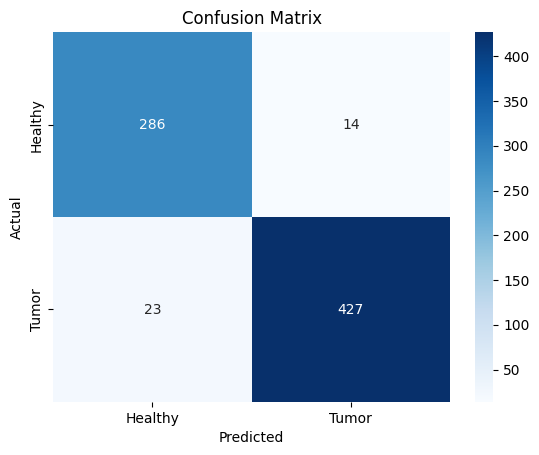

              precision    recall  f1-score   support

     Healthy       0.93      0.95      0.94       300
       Tumor       0.97      0.95      0.96       450

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750



In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


### Optimizer Comparison: Adam vs. SGD

Below is a side-by-side comparison of the first CNN model (3×3 conv kernels) trained with **Adam** (learning_rate=0.0005) versus **SGD** (learning_rate=0.001, momentum=0.9).

| Metric                 | Adam        | SGD         |
|------------------------|-------------|-------------|
| **Healthy Precision**  | 0.97        | 0.93        |
| **Healthy Recall**     | 0.99        | 0.95        |
| **Tumor Precision**    | 0.99        | 0.97        |
| **Tumor Recall**       | 0.98        | 0.95        |
| **Overall Accuracy**   | 0.99        | 0.95        |
| **Macro F1-score**     | 0.98        | 0.95        |
| **Weighted F1-score**  | 0.99        | 0.95        |

**Key Takeaways:**

- **Adam** converged faster and achieved higher precision, recall, and overall accuracy (0.99) compared to **SGD** (0.95 accuracy).  
- The gap is most pronounced in the “Healthy” class, where Adam’s recall (0.99) greatly reduces false negatives.  
- **SGD** still performs reasonably well but may require more epochs or a refined learning-rate schedule to match Adam’s performance.  
- Depending on application requirements—e.g., minimizing missed tumors vs. computational budget—either optimizer could be chosen or further tuned.  


### 18. Define Second CNN Architecture (5×5 Kernels)

In this variant, we replace the 3×3 kernels with larger 5×5 kernels in both convolutional blocks to capture broader spatial features:



In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization

model1 = Sequential()
    
model1.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
    
model1.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))
    
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(2, activation='softmax'))

C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 19. Training Second Model (5×5 Kernels) with Adam

In this step, we train the `model1` architecture—using larger 5×5 convolution kernels—with the same Adam optimizer and callback setup:

1. **Hyperparameters**  
   - `batch_size = 32`  
   - `epochs = 100`  

2. **Compile**  
   - **Optimizer**: Adam (learning rate = 0.0005)  
   - **Loss**: `categorical_crossentropy`  
   - **Metric**: `accuracy`  

3. **Callbacks**  
   - **ReduceLROnPlateau**: monitor `val_loss`, halve LR (factor=0.5) after 5 epochs without improvement (min LR = 1e-5)  
   - **EarlyStopping**: monitor `val_loss`, stop after 10 epochs without improvement, restore best weights  

4. **Train** using the same `data_generator` for augmentation and validation on `(X_valid, y_valid)`


In [24]:
batch_size = 32

epochs = 100

optimizer = Adam(learning_rate=0.0005)

model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

model1.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


Epoch 1/100


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 26s - 232ms/step - accuracy: 0.7671 - loss: 0.7311 - val_accuracy: 0.8053 - val_loss: 0.7254 - learning_rate: 5.0000e-04
Epoch 2/100
110/110 - 22s - 204ms/step - accuracy: 0.8749 - loss: 0.2939 - val_accuracy: 0.8293 - val_loss: 0.5075 - learning_rate: 5.0000e-04
Epoch 3/100
110/110 - 23s - 205ms/step - accuracy: 0.8903 - loss: 0.2541 - val_accuracy: 0.8867 - val_loss: 0.2950 - learning_rate: 5.0000e-04
Epoch 4/100
110/110 - 22s - 203ms/step - accuracy: 0.9143 - loss: 0.2083 - val_accuracy: 0.9253 - val_loss: 0.1852 - learning_rate: 5.0000e-04
Epoch 5/100
110/110 - 22s - 203ms/step - accuracy: 0.9277 - loss: 0.1768 - val_accuracy: 0.8827 - val_loss: 0.2522 - learning_rate: 5.0000e-04
Epoch 6/100
110/110 - 22s - 200ms/step - accuracy: 0.9240 - loss: 0.1821 - val_accuracy: 0.8787 - val_loss: 0.2915 - learning_rate: 5.0000e-04
Epoch 7/100
110/110 - 22s - 199ms/step - accuracy: 0.9383 - loss: 0.1533 - val_accuracy: 0.9267 - val_loss: 0.1871 - learning_rate: 5.0000e-04
Epoch 8/100

### 20. Training History Visualization for Second Model (5×5 Kernels)

Plot the evolution of training and validation loss and accuracy over epochs for `model1` to assess convergence and potential overfitting:

- **Left subplot**: Training vs. validation loss  
- **Right subplot**: Training vs. validation accuracy  

This visualization helps compare how the 5×5–kernel model learns relative to the original architecture.


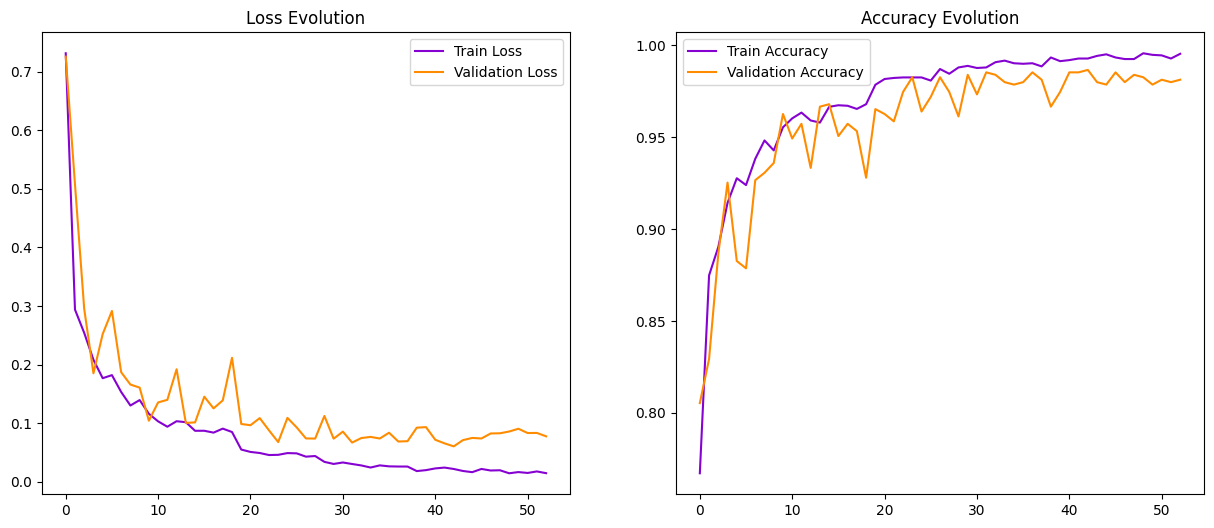

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(model1.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model1.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(model1.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model1.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

### 21. Model Evaluation on Test Set for Second Model (5×5 Kernels)

Evaluate `model1` on the held-out test set to measure its generalization performance:



In [32]:
test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9765 - loss: 0.0971

Test Accuracy: 0.981333315372467
Test Loss:     0.07105901837348938


### 22. Confusion Matrix & Classification Report for Second Model (5×5 Kernels)

- **Predictions**: Use `model1.predict()` on `X_test` and convert probabilities to class indices.  
- **Confusion Matrix**: Compute and plot the matrix to visualize True Positives, True Negatives, False Positives, and False Negatives.  
- **Classification Report**: Display precision, recall, F1-score, and support for “Healthy” and “Tumor” classes to assess detailed performance.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


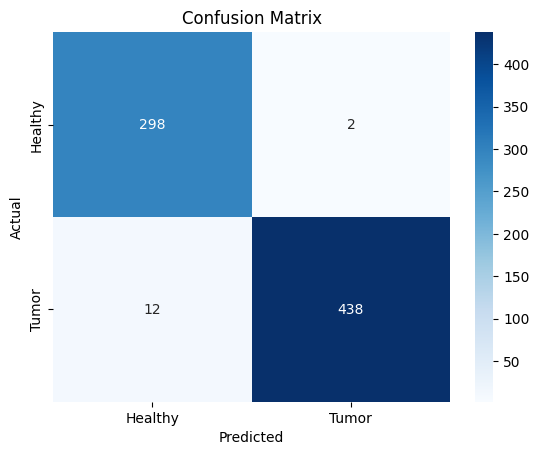

              precision    recall  f1-score   support

     Healthy       0.96      0.99      0.98       300
       Tumor       1.00      0.97      0.98       450

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


### 23. Results Interpretation for Second Model (5×5 Kernels)

The classification report for the 5×5–kernel model shows:

- **Healthy class**  
  - **Precision = 0.96**: 96% of scans predicted “Healthy” are correct.  
  - **Recall = 0.99**: 99% of actual healthy scans are correctly identified.  
  - **F1-score = 0.98**: High balance between precision and recall.

- **Tumor class**  
  - **Precision = 1.00**: All scans predicted “Tumor” are truly tumor cases (no false positives).  
  - **Recall = 0.97**: 97% of actual tumor scans are detected (few false negatives).  
  - **F1-score = 0.98**: Excellent trade-off between precision and recall.

- **Overall accuracy = 0.98**: 98% of test images correctly classified.  
- **Macro average** = 0.98 precision, 0.98 recall, 0.98 F1-score (unweighted mean across classes).  
- **Weighted average** = 0.98 precision, 0.98 recall, 0.98 F1-score (accounts for class support).

**Comparison to 3×3–kernel model**:  
- Slight drop in overall accuracy (from 0.99 to 0.98),  
- Perfect precision on “Tumor” predictions but a slight decrease in recall,  
- Similar F1-scores for both classes.  

This indicates the larger kernels capture broader features but may slightly trade sensitivity for specificity. Depending on the clinical priority (minimizing missed tumors vs. minimizing false alarms), you can choose between these architectures or further ensemble them.  


### 24. Single Image Inference with Second Model (5×5 Kernels)

Run inference on a new MRI scan using `model1` (the 5×5–kernel architecture):

1. **Load** the image from disk using OpenCV  
2. **Resize** to the model’s input dimensions (e.g., 128×128)  
3. **Normalize** pixel values to [0,1]  
4. **Add a batch dimension** to create a shape of `(1, height, width, channels)`  
5. **Predict** class probabilities with `model1.predict()`  
6. **Determine** the class label (“Healthy” vs. “Tumor”) by taking the `argmax`


In [34]:
img_path = "D:\\Sisteme inteligente\\scientificProject3\\data\\healthy.jpg"

img = cv2.imread(img_path)

img_resized = cv2.resize(img, (X_train.shape[1], X_train.shape[2]))  

img_normalized = img_resized / 255.0

img_input = np.expand_dims(img_normalized, axis=0)

prediction = model1.predict(img_input)

class_index = np.argmax(prediction)

class_names = ["Healthy", "Tumor"]
print(f"Predicted class: {class_names[class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: Tumor


## 25. Define CNN Third Model Architecture

### Block 1: 2 conv layers

- **Conv2D(8, 5×5, relu, same)**: Extract basic edge and texture features with 8 filters  
- **BatchNormalization**: Stabilize learning by normalizing activations  
- **Conv2D(8, 5×5, relu, same)**: Deepen the feature representation at the same resolution  
- **BatchNormalization**  
- **MaxPooling2D(2×2)**: Downsample spatial dimensions by 50%  
- **Dropout(0.2)**: Randomly drop 20% of activations to prevent overfitting  


### 2. Block 2: Mid-Level Feature Extraction

- **Conv2D(16, 5×5, relu, same)**: Capture more complex patterns with increased filter count  
- **BatchNormalization**  
- **Conv2D(16, 3×3, relu, same)**: Refine features with a smaller receptive field  
- **BatchNormalization**  
- **MaxPooling2D(2×2)**: Further spatial reduction  
- **Dropout(0.3)**: Drop 30% of activations  


### 3. Block 3: High-Level Feature Extraction

- **Conv2D(32, 5×5, relu, same)**: High-capacity layer for abstract features  
- **BatchNormalization**  
- **MaxPooling2D(2×2)**: Final spatial downsampling  
- **Dropout(0.4)**: Drop 40% of activations to regularize  


### 4. Fully Connected Classification Head

- **Flatten**: Convert 3D feature maps into a 1D vector  
- **Dense(64, relu)**: Learn non-linear combinations of features  
- **Dropout(0.5)**: Drop 50% of neurons to prevent co-adaptation  
- **Dense(2, softmax)**: Output probabilities for “Healthy” vs. “Tumor”  


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

model2 = Sequential()

model2.add(Conv2D(8, kernel_size=(5,5), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model2.add(BatchNormalization())
model2.add(Conv2D(8, kernel_size=(5,5), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.3))

model2.add(Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.4))

model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 26. Training Third Model (Deeper CNN with 5 Convolutional Layers)

In this step, we’ll train **model2**, the deeper architecture with five convolutional layers, using the same training setup as before:

1. **Hyperparameters**  
   - `batch_size = 32`  
   - `epochs = 100`  

2. **Compile the model**  
   - **Optimizer**: Adam (learning rate = 0.0005)  
   - **Loss**: `categorical_crossentropy`  
   - **Metric**: `accuracy`

3. **Configure callbacks**  
   - **ReduceLROnPlateau**: monitor `val_loss`, reduce LR by half after 5 epochs without improvement (min LR = 1e-5)  
   - **EarlyStopping**: monitor `val_loss`, stop after 10 epochs without improvement and restore best weights  

4. **Launch training** on the augmented data generator and validate on `(X_valid, y_valid)`:



In [44]:

batch_size = 32

epochs = 100

optimizer = Adam(learning_rate=0.0005)


model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


model2.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


Epoch 1/100


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 25s - 229ms/step - accuracy: 0.7217 - loss: 0.6839 - val_accuracy: 0.6000 - val_loss: 2.8252 - learning_rate: 5.0000e-04
Epoch 2/100
110/110 - 22s - 199ms/step - accuracy: 0.8314 - loss: 0.3797 - val_accuracy: 0.6280 - val_loss: 3.8851 - learning_rate: 5.0000e-04
Epoch 3/100
110/110 - 22s - 199ms/step - accuracy: 0.8520 - loss: 0.3342 - val_accuracy: 0.7507 - val_loss: 1.0637 - learning_rate: 5.0000e-04
Epoch 4/100
110/110 - 22s - 200ms/step - accuracy: 0.8669 - loss: 0.2988 - val_accuracy: 0.8667 - val_loss: 0.4057 - learning_rate: 5.0000e-04
Epoch 5/100
110/110 - 22s - 199ms/step - accuracy: 0.8826 - loss: 0.2617 - val_accuracy: 0.8867 - val_loss: 0.2419 - learning_rate: 5.0000e-04
Epoch 6/100
110/110 - 22s - 200ms/step - accuracy: 0.8863 - loss: 0.2603 - val_accuracy: 0.8747 - val_loss: 0.3662 - learning_rate: 5.0000e-04
Epoch 7/100
110/110 - 22s - 201ms/step - accuracy: 0.8917 - loss: 0.2327 - val_accuracy: 0.9093 - val_loss: 0.2417 - learning_rate: 5.0000e-04
Epoch 8/100

### 27. Confusion Matrix & Classification Report for third model (Deeper CNN)

Evaluate the deeper third model on the test set:

1. **Predict** class probabilities with `model2.predict(X_test)`  
2. **Convert** probabilities to class indices using `np.argmax`  
3. **Compute** the confusion matrix to see True/False Positives/Negatives  
4. **Plot** the confusion matrix as a heatmap with labels “Healthy” and “Tumor”  
5. **Print** a detailed classification report (precision, recall, F1-score) for each class  


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


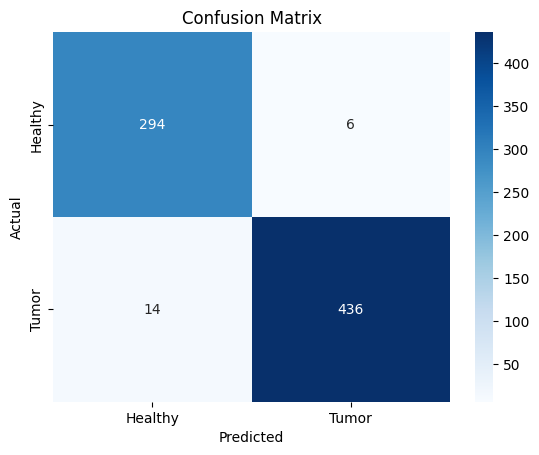

              precision    recall  f1-score   support

     Healthy       0.95      0.98      0.97       300
       Tumor       0.99      0.97      0.98       450

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


The confusion matrix and classification report for the third model show:

- **Healthy class**  
  - **Precision = 0.95**: 95% of scans predicted “Healthy” are correct.  
  - **Recall = 0.98**: 98% of actual healthy scans are correctly identified.  
  - **F1-score = 0.97**: Strong overall balance between precision and recall.

- **Tumor class**  
  - **Precision = 0.99**: 99% of scans predicted “Tumor” are truly tumor cases (very few false positives).  
  - **Recall = 0.97**: 97% of actual tumor scans are detected (few false negatives).  
  - **F1-score = 0.98**: Excellent trade-off between precision and recall.

- **Overall accuracy = 0.97**: 97% of all test images are correctly classified.

### 28. Define CNN fourth Model Architecture

This architecture uses five 3×3 convolutional layers across three blocks, combining depth with small receptive fields for fine-grained feature extraction:



In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD

model3 = Sequential()

model3.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model3.add(BatchNormalization())
model3.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.4))

model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 29. Training the fourth model(Deeper CNN with 3×3 Kernels)

In this step, we train **model3**, the deeper architecture with five 3×3 convolutional layers, using the same setup as before:

1. **Hyperparameters**  
   - `batch_size = 32`  
   - `epochs = 100`  

2. **Compile the model**  
   - **Optimizer**: Adam (learning rate = 0.0005)  
   - **Loss**: `categorical_crossentropy`  
   - **Metric**: `accuracy`

3. **Configure callbacks**  
   - **ReduceLROnPlateau**: monitor `val_loss`, reduce LR by half after 5 epochs without improvement (min LR = 1e-5)  
   - **EarlyStopping**: monitor `val_loss`, stop after 10 epochs without improvement and restore best weights  

4. **Launch training** on the augmented data generator and validate on `(X_valid, y_valid)`:


In [38]:
batch_size = 32

epochs = 100

optimizer = Adam(learning_rate=0.0005)

model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

model3.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


Epoch 1/100


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 26s - 238ms/step - accuracy: 0.7337 - loss: 0.6535 - val_accuracy: 0.6827 - val_loss: 0.8451 - learning_rate: 5.0000e-04
Epoch 2/100
110/110 - 24s - 215ms/step - accuracy: 0.7963 - loss: 0.4191 - val_accuracy: 0.7467 - val_loss: 0.9553 - learning_rate: 5.0000e-04
Epoch 3/100
110/110 - 23s - 207ms/step - accuracy: 0.8217 - loss: 0.3821 - val_accuracy: 0.8067 - val_loss: 0.6600 - learning_rate: 5.0000e-04
Epoch 4/100
110/110 - 20s - 184ms/step - accuracy: 0.8354 - loss: 0.3501 - val_accuracy: 0.8760 - val_loss: 0.4911 - learning_rate: 5.0000e-04
Epoch 5/100
110/110 - 20s - 182ms/step - accuracy: 0.8586 - loss: 0.3131 - val_accuracy: 0.8693 - val_loss: 0.3649 - learning_rate: 5.0000e-04
Epoch 6/100
110/110 - 20s - 182ms/step - accuracy: 0.8714 - loss: 0.2946 - val_accuracy: 0.8800 - val_loss: 0.3328 - learning_rate: 5.0000e-04
Epoch 7/100
110/110 - 20s - 184ms/step - accuracy: 0.8766 - loss: 0.2681 - val_accuracy: 0.8920 - val_loss: 0.3370 - learning_rate: 5.0000e-04
Epoch 8/100

### 30. Training History Visualization for fourth model

Plot the evolution of training and validation loss and accuracy over epochs for `model3` to assess convergence behavior and potential overfitting:

- **Left subplot**:  
  - Training Loss vs. Validation Loss  
  - Helps identify if the model is learning smoothly or if validation loss starts increasing (overfitting).

- **Right subplot**:  
  - Training Accuracy vs. Validation Accuracy  
  - Shows how well the model generalizes across epochs.


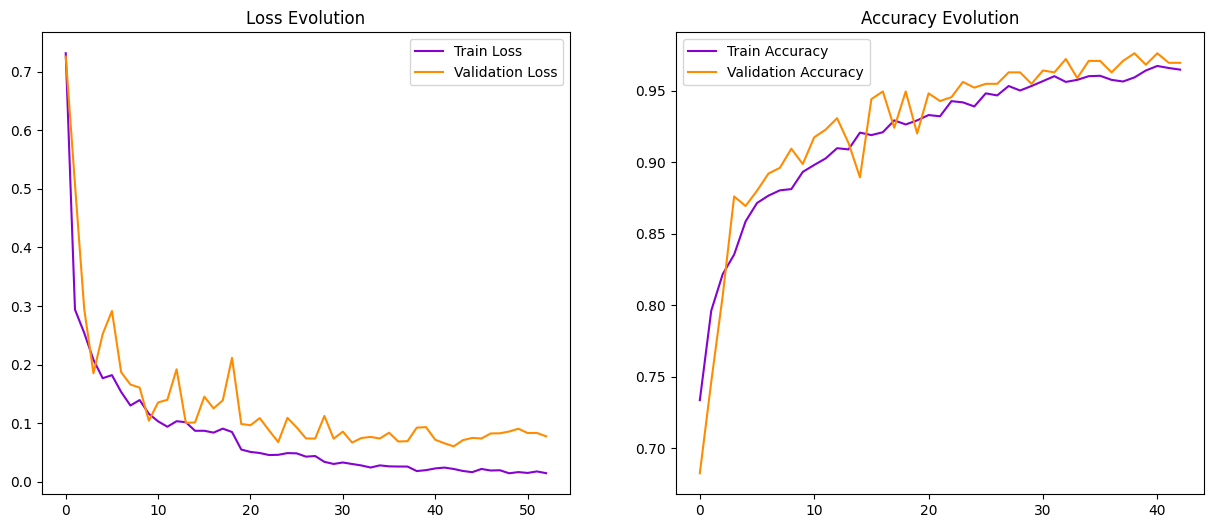

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(model1.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(model1.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(model3.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(model3.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [41]:
test_loss, test_acc = model3.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9708 - loss: 0.0855

Test Accuracy: 0.9733333587646484
Test Loss:     0.09029719978570938


### 31. Confusion Matrix & Classification Report for fourth model

After training the deeper 3×3–kernel model (`model3`), evaluate its performance on the test set:

1. **Predict** probabilities on `X_test` and convert to class indices with `np.argmax`.  
2. **Compute** the confusion matrix to see counts of True/False Positives/Negatives.  
3. **Plot** the confusion matrix as a heatmap with class labels “Healthy” and “Tumor.”  
4. **Generate** a classification report showing precision, recall, F1-score, and support for each class.


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


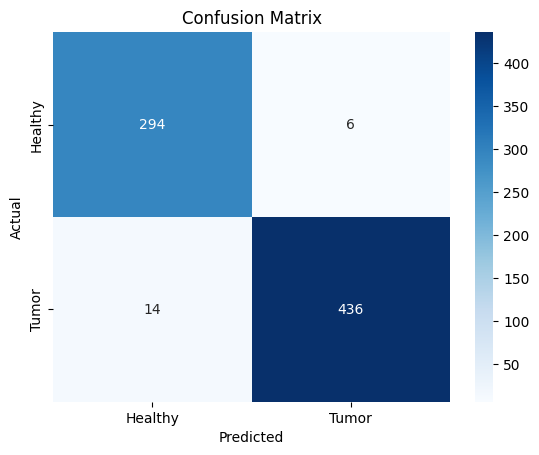

              precision    recall  f1-score   support

     Healthy       0.95      0.98      0.97       300
       Tumor       0.99      0.97      0.98       450

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


### 32. Comparison of Multi-Layer Models (model2 vs. model3)

Below is a side-by-side comparison of the two deeper CNNs, each with five convolutional layers but differing in kernel configuration:

| Metric                 | model2 (mixed 5×5 & 3×3) | model3 (all 3×3) |
|------------------------|--------------------------|------------------|
| **Healthy Precision**  | 0.95                     | 0.95             |
| **Healthy Recall**     | 0.98                     | 0.98             |
| **Healthy F1-score**   | 0.97                     | 0.97             |
| **Tumor Precision**    | 0.99                     | 0.99             |
| **Tumor Recall**       | 0.97                     | 0.97             |
| **Tumor F1-score**     | 0.98                     | 0.98             |
| **Overall Accuracy**   | 0.97                     | 0.97             |

**Interpretation:**  
- Both architectures achieve essentially identical performance on the test set (97% accuracy), with the same balance of precision and recall for each class.  
- The mixed-kernel model (model2) captures both broad (5×5) and fine (3×3) features, while the uniform 3×3 model (model3) focuses on finer local patterns.  
- Since their test metrics are the same, you can choose based on other criteria (e.g., computational cost or inference speed), or ensemble them to potentially boost robustness.  


### 33. Single Image Inference with fourth model

- **Load** a new MRI image from disk  
- **Resize** it to match the model’s input dimensions (e.g., 128×128)  
- **Normalize** pixel values to [0,1] (same preprocessing as training)  
- **Add** a batch dimension to create a `(1, H, W, C)` input  
- **Predict** class probabilities using `model3.predict()`  
- **Map** the predicted index to the label “Healthy” or “Tumor” and print the result



In [55]:
img_path = "D:\\Sisteme inteligente\\scientificProject3\\data\\healthy2.jpg"

img = cv2.imread(img_path)

img_resized = cv2.resize(img, (X_train.shape[1], X_train.shape[2]))

img_normalized = img_resized / 255.0

img_input = np.expand_dims(img_normalized, axis=0)


prediction = model3.predict(img_input)

class_index = np.argmax(prediction)

class_names = ["Healthy", "Tumor"]
print(f"Predicted class: {class_names[class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: Tumor


### 34. Re-Training the fourth model with SGD Optimizer

To evaluate the impact of optimizer choice on the deeper 3×3–kernel model, we now recompile and train **model3** using **Stochastic Gradient Descent (SGD)** with momentum, keeping all other settings identical:

1. **Hyperparameters**  
   - `batch_size = 32`  
   - `epochs = 100`  

2. **Compile Model3**  
   - **Optimizer**: SGD (learning rate = 0.001, momentum = 0.9)  
   - **Loss**: `categorical_crossentropy`  
   - **Metric**: `accuracy`

3. **Callbacks**  
   - **ReduceLROnPlateau**: monitor `val_loss`, reduce LR by half after 5 epochs without improvement (min LR = 1e-5)  
   - **EarlyStopping**: monitor `val_loss`, stop after 10 epochs without improvement and restore best weights  

4. **Train** on the augmented data generator, validating on `(X_valid, y_valid)`:



In [61]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

batch_size = 32

epochs = 100

optimizer = SGD(learning_rate=0.001, momentum=0.9)

model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              min_lr=1e-5,
                              verbose=1)


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

model3.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[reduce_lr, early_stopping],
    verbose=2
)


C:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
110/110 - 46s - 417ms/step - accuracy: 0.9511 - loss: 0.1161 - val_accuracy: 0.9413 - val_loss: 0.2251 - learning_rate: 0.0010
Epoch 2/100
110/110 - 30s - 273ms/step - accuracy: 0.9531 - loss: 0.1157 - val_accuracy: 0.8507 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 3/100
110/110 - 29s - 266ms/step - accuracy: 0.9517 - loss: 0.1153 - val_accuracy: 0.9640 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 4/100
110/110 - 29s - 264ms/step - accuracy: 0.9546 - loss: 0.1093 - val_accuracy: 0.9680 - val_loss: 0.1294 - learning_rate: 0.0010
Epoch 5/100
110/110 - 31s - 286ms/step - accuracy: 0.9546 - loss: 0.1020 - val_accuracy: 0.9627 - val_loss: 0.1767 - learning_rate: 0.0010
Epoch 6/100
110/110 - 28s - 258ms/step - accuracy: 0.9554 - loss: 0.1055 - val_accuracy: 0.9627 - val_loss: 0.1129 - learning_rate: 0.0010
Epoch 7/100
110/110 - 26s - 236ms/step - accuracy: 0.9626 - loss: 0.0946 - val_accuracy: 0.9600 - val_loss: 0.1791 - learning_rate: 0.0010
Epoch 8/100
110/110 - 30s -

### 32. Confusion Matrix & Classification Report for fourth model (SGD)

After retraining **model3** with the SGD optimizer, evaluate its performance on the test set:


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


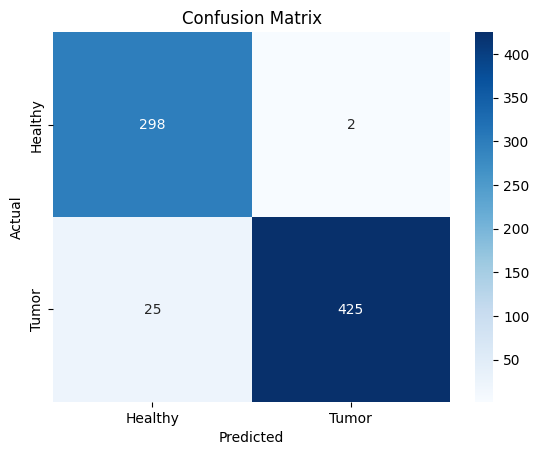

              precision    recall  f1-score   support

     Healthy       0.92      0.99      0.96       300
       Tumor       1.00      0.94      0.97       450

    accuracy                           0.96       750
   macro avg       0.96      0.97      0.96       750
weighted avg       0.97      0.96      0.96       750



In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=['Healthy', 'Tumor']))


### 33. Multi-Layer Model Comparison (Adam vs. SGD)

Below is a summary of the two deeper CNNs (each with 5 convolutional layers) under different optimizer settings:

| Model                         | Kernels           | Optimizer    | Accuracy | Healthy (P / R / F1) | Tumor (P / R / F1) |
|-------------------------------|-------------------|--------------|----------|----------------------|--------------------|
| **model2**                    | mixed 5×5 & 3×3   | Adam         | 0.97     | 0.95 / 0.98 / 0.97   | 0.99 / 0.97 / 0.98 |
| **model3**                    | all 3×3           | Adam         | 0.97     | 0.95 / 0.98 / 0.97   | 0.99 / 0.97 / 0.98 |
| **model3 (retrained with SGD)** | all 3×3         | SGD (0.001, 0.9) | 0.96     | 0.92 / 0.99 / 0.96   | 1.00 / 0.94 / 0.97 |

**Interpretation:**

- Both **model2** and **model3** trained with Adam reach identical performance (97% accuracy), demonstrating that mixing kernel sizes (model2) or using uniform 3×3 kernels (model3) yields equivalent results under this setup.
- Switching to SGD for **model3** leads to a slight drop in overall accuracy (96%) and precision on the “Healthy” class (from 95%→92%), though tumor precision improves to 100%.  
- The Adam-trained versions strike the best balance of sensitivity (recall) and specificity. If absolute tumor precision is paramount, SGD’s perfect precision on “Tumor” may be attractive, at the cost of more missed tumors (recall 94% vs. 97%).  
- Ultimately, the Adam-trained deep models offer the strongest generalization, while the SGD variant could be chosen if minimizing false positives is the primary objective.  
